In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd
#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20, 15)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))

In [5]:
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [6]:
hf.close()

### Problem 1 

#### 1) Down load the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

In [7]:
# define a function to plot only sections of the data
def plot_section(start,lenth,x,y, bins, plot, legend):
    if plot == 'hist':
        plt.hist(x[start:start+lenth],weights = y[start:start+lenth], bins = bins)
    else:
        plt.scatter(x[start:start+lenth], y[start:start+lenth], label = legend)

In [8]:
# make a table to describe the columns and data
Data = pd.DataFrame({'Time':data[0], 'Solar Phase' : data[1] , 'Earth Longitude':data[2], 'Particle Count':data[3]})
Data.columns

Index(['Time', 'Solar Phase', 'Earth Longitude', 'Particle Count'], dtype='object')

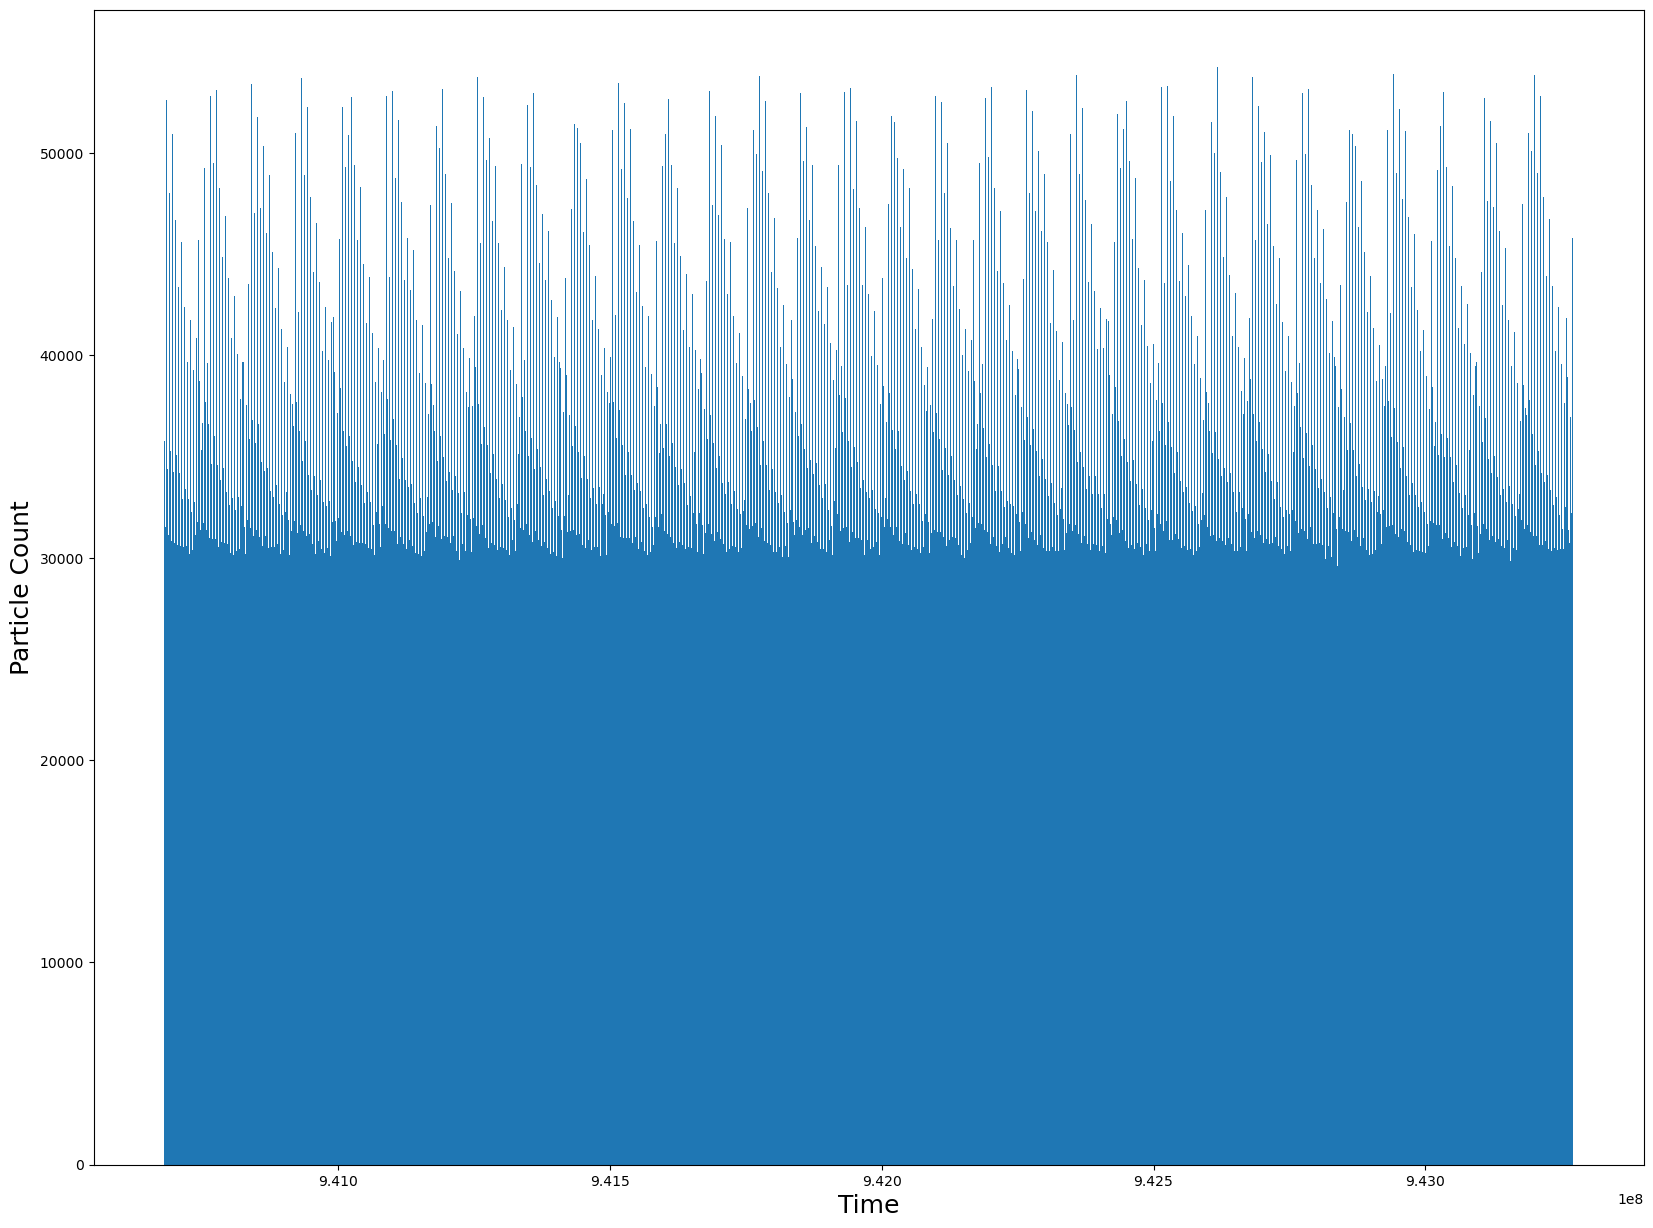

In [9]:
# plot a section of the particle counts and time
plot_section(0, len(Data['Time']), Data['Time'], Data['Particle Count'], 5000, 'hist', '')
plt.xlabel('Time', fontsize = '18')
plt.ylabel('Particle Count', fontsize = 18)
plt.show()

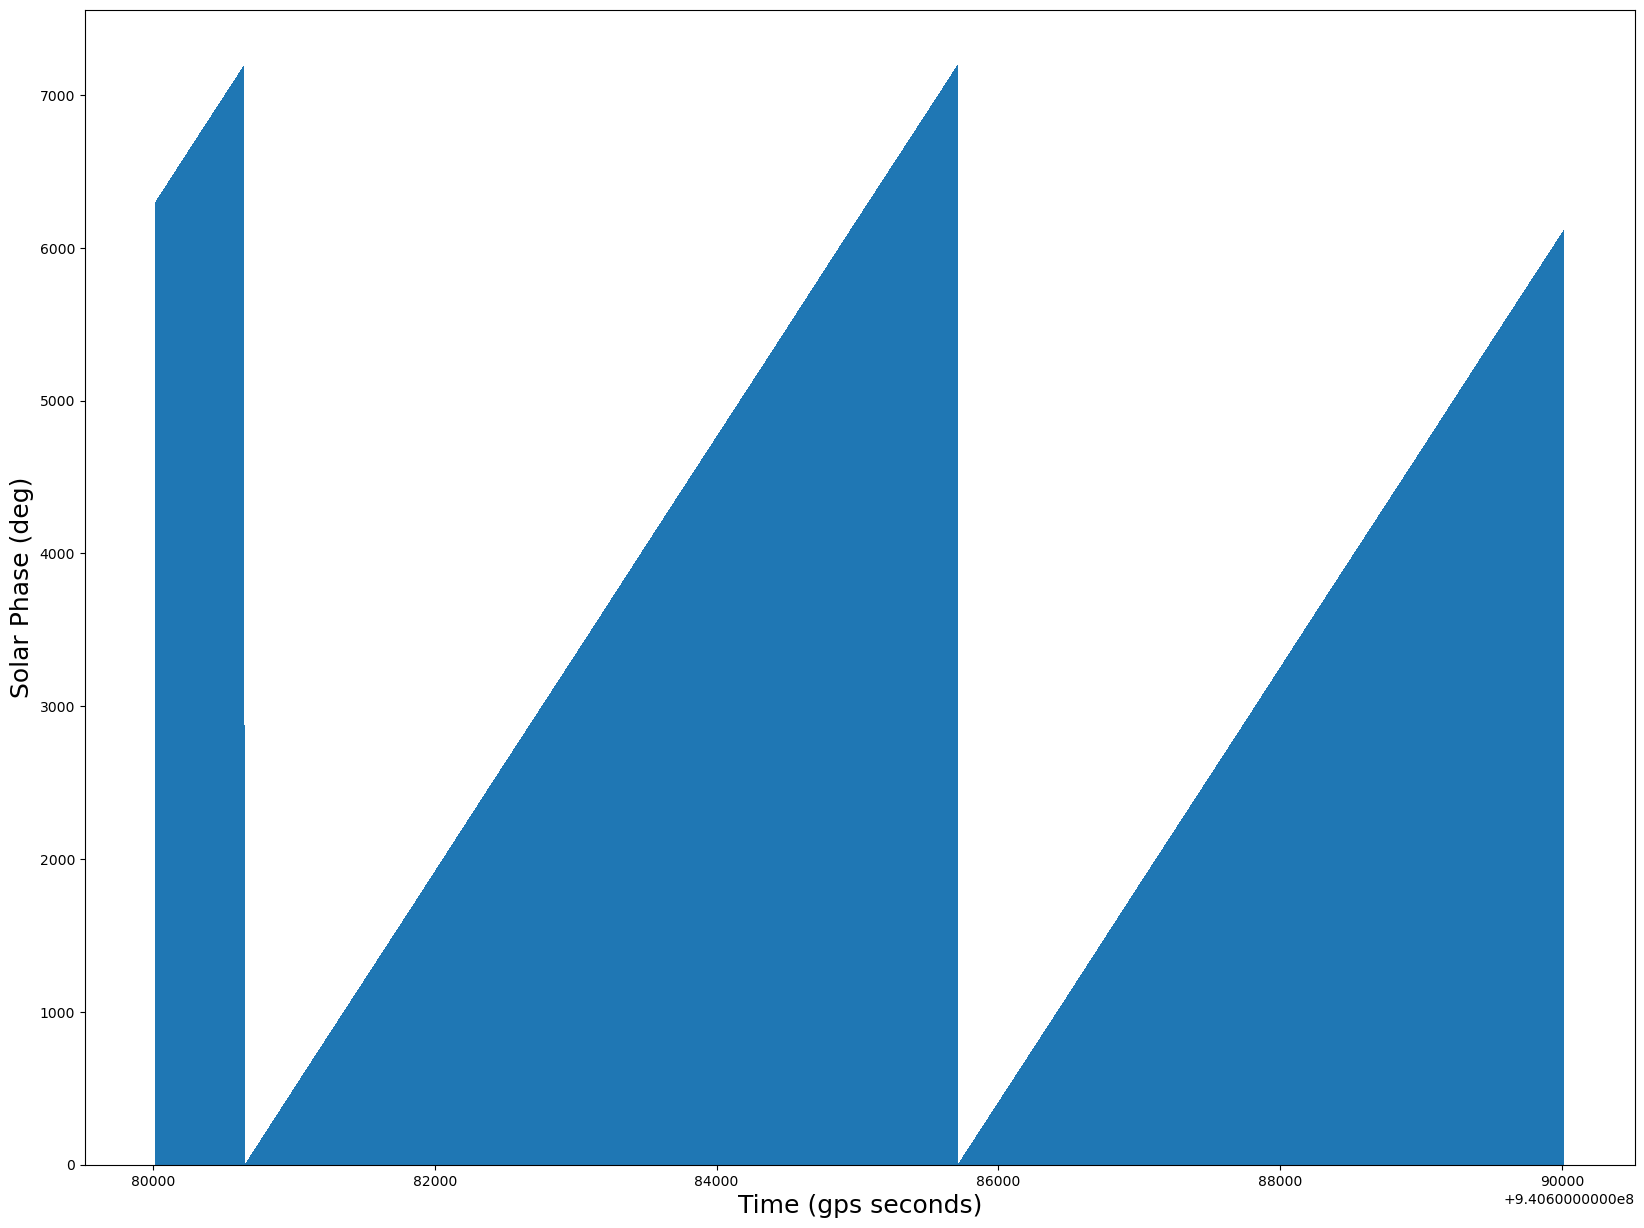

In [10]:
plot_section(0, 100000, Data['Time'], Data['Solar Phase'], 5000, 'hist', '')
plt.xlabel('Time (gps seconds)', fontsize = 18)
plt.ylabel('Solar Phase (deg)', fontsize =18)
plt.show()

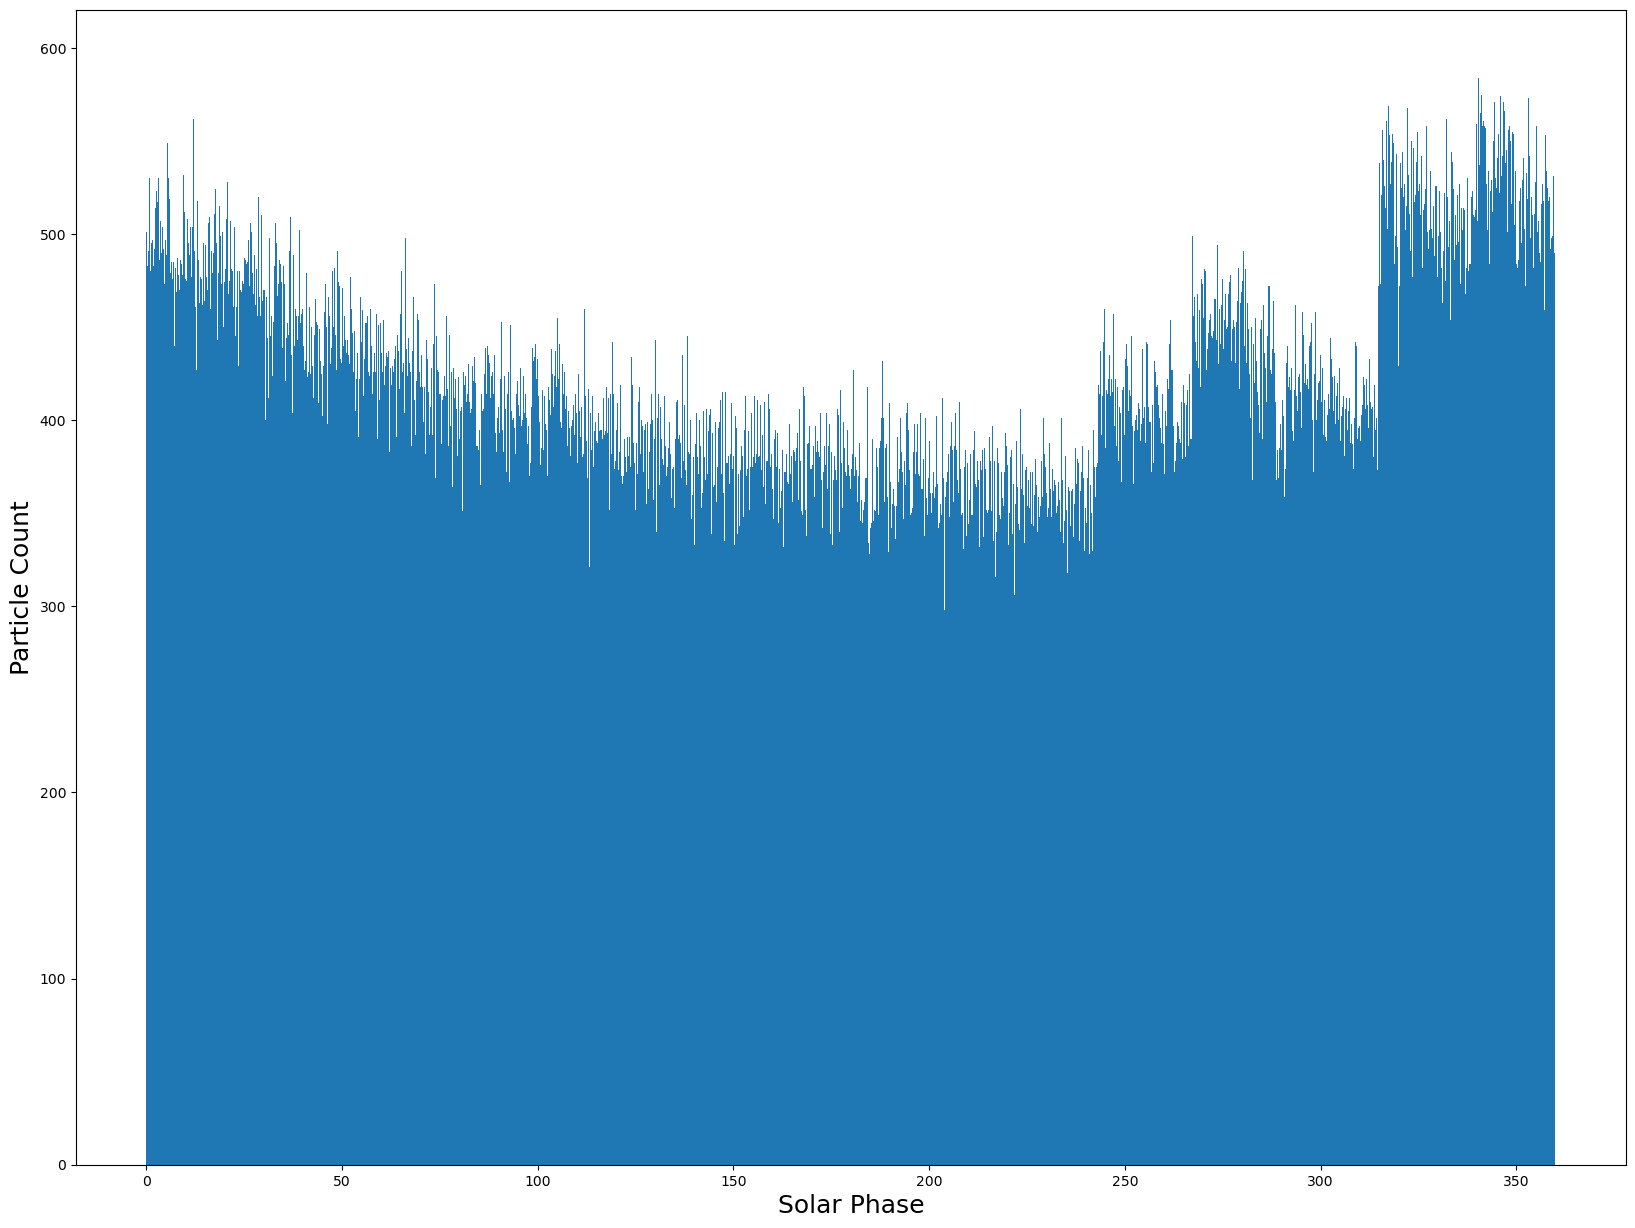

In [11]:
plot_section(0, 300000, Data['Solar Phase'], Data['Particle Count'], 5000, 'hist', '')
plt.xlabel('Solar Phase', fontsize = 18)
plt.ylabel('Particle Count', fontsize =18)
plt.show()

There does not appear to be a relation between the particle count and the solar phase, so let us explore more of the Earth phase data. 

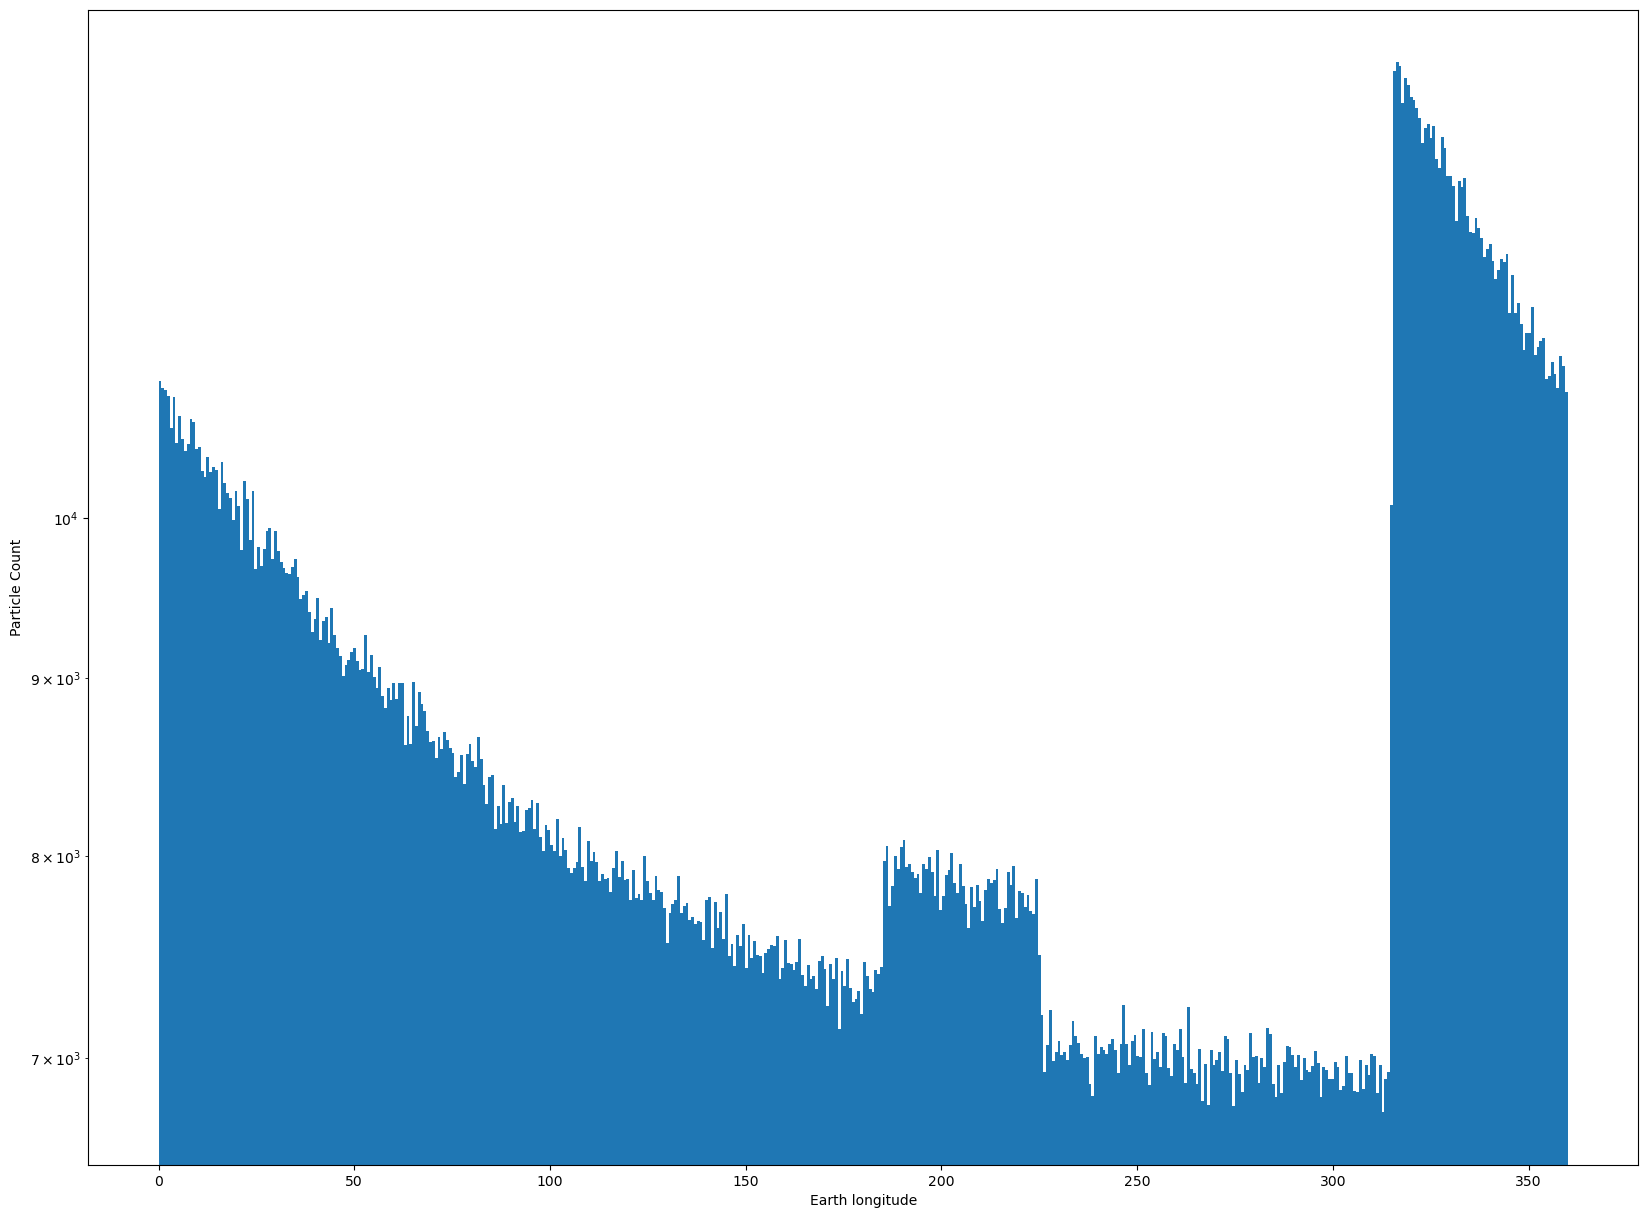

In [12]:
plot_section(75000, 600000, Data['Earth Longitude'], Data['Particle Count'], 500, 'hist', '')
plt.xlabel('Earth longitude')
plt.ylabel('Particle Count')
plt.yscale('log')
plt.show()

Both the solar phase and the earth phase have its own periodic characteristic. This makes sense given that we know the period is about 90 minutes (5400 gps). The particle count for the earth longitude appears to be exponentially decaying, and we will explore this more for our background. 

#### 2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

We can start by looking at plots comparing the different changes in the background distribution. 

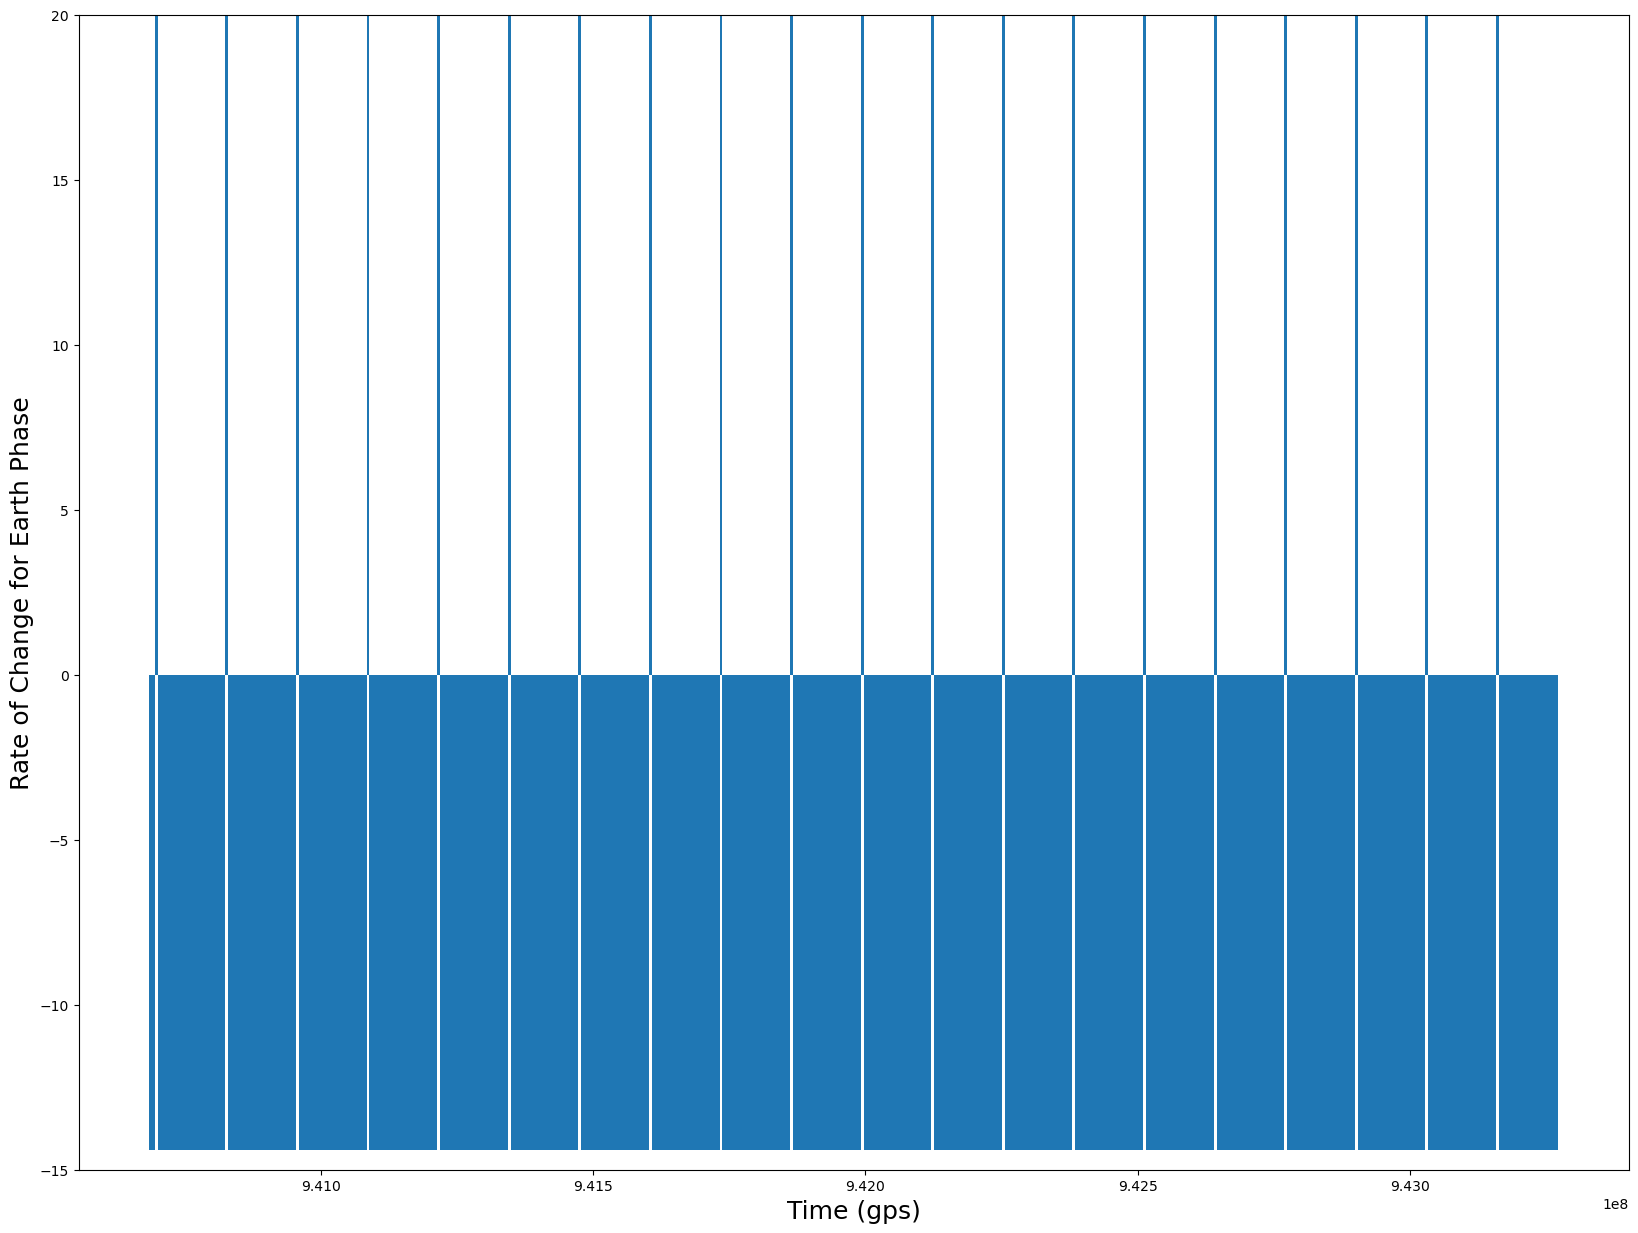

In [13]:
rate = Data['Earth Longitude'].diff()
plot_section(0, len(Data['Time']), Data['Time'], rate, 500, 'hist', '')
plt.ylim([-15, 20])
plt.ylabel('Rate of Change for Earth Phase', fontsize =18)
plt.xlabel('Time (gps)', fontsize = 18)
plt.show()

The Earth phase's rate of change does not appear to be constant, which we can use to find significance of signals after creating a background distribution related to Earth's phase and particle count. 

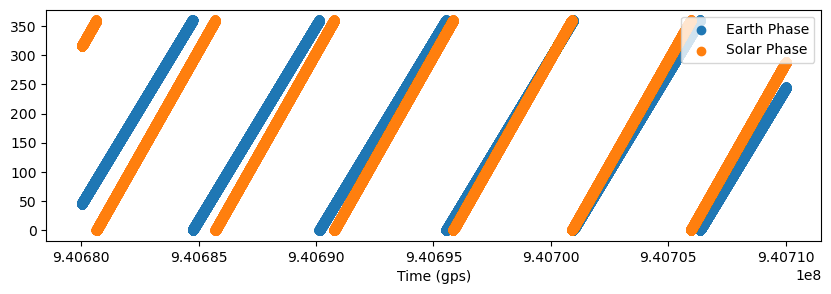

In [28]:
plot_section(0, 300000, Data['Time'], Data['Earth Longitude'], 0, 'scatter', 'Earth Phase')
plot_section(0, 300000, Data['Time'], Data['Solar Phase'], 0, 'scatter', 'Solar Phase')
plt.legend()
plt.xlabel('Time (gps)')
plt.show()

Another plot to show the solar and Earth phase trend over time. The Solar phase appears consistent over time, but we can see the earth phase shift from behind to ahead of the solar phase, affirming our suspicion of the Earth phase's inconsistency. 

#### 3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background

We can try to model the background with a Poisson distribution since we know we are dealing with independent events over a period of time. We will use the Earth phase since we found that the particle count is independent from Earth phase. To build a Poisson distribution we can use the mean of specific Earth Phase values and build a plot and a semi log plot to find a good Gaussian distribution to calculate sigma values. 

In [51]:
def bg_spread(n):

    D = Data[(Data["Earth Longitude"] < Data.at[n+15,'Earth Longitude'])]
    D = D[(D["Earth Longitude"] >= Data.at[n-15,'Earth Longitude'])]
    
    mu=D.mean()
    
    fig, ax = plt.subplots(1,1)
    x = np.arange(0,30,1)
    ax.plot(x,stats.poisson.pmf(x,mu[3],loc=0), linewidth = 5, alpha = .5,label = 'Background Model')
    plt.xlim([0,25])
    plt.hist(D['Particle Count'], bins=np.arange(0,40,1), density=True, color = 'skyblue', label =  'Data Background')
    plt.yscale('log')
    plt.ylabel('Frequency')
    plt.xlabel('Particle Count')
    plt.title('Background for Earth Phase = {0:1.2f}'.format(Data.at[n,'Earth Longitude']))
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(1,1)
    x = np.arange(0,30,1)
    ax.plot(x,stats.poisson.pmf(x,mu[3],loc=0), linewidth = 5, alpha = .5, label = 'Background Model')
    #plt.matplotlib.pyplot.step(x,stats.poisson.pmf(x,mu[3],loc=0))
    plt.hist(D['Particle Count'], bins=np.arange(0,40,1), density=True, color = 'skyblue',align='left',label = 'Data Background')
    plt.xlim([0,25])
    plt.ylabel('Frequency')
    plt.title('Background for Earth Phase = {0:1.2f}'.format(Data.at[n,'Earth Longitude']))
    plt.xlabel('Particle Count')
    plt.legend()
    plt.show()

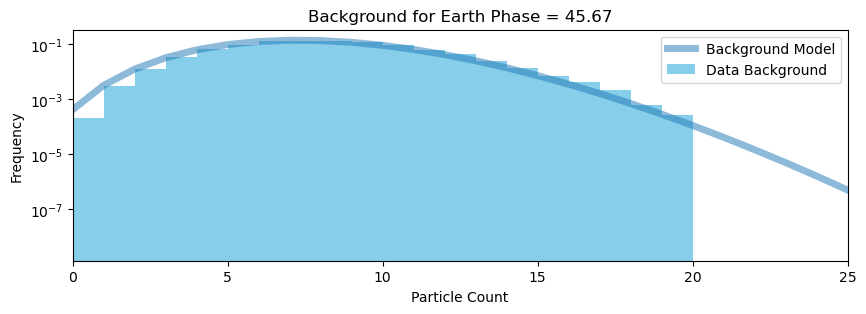

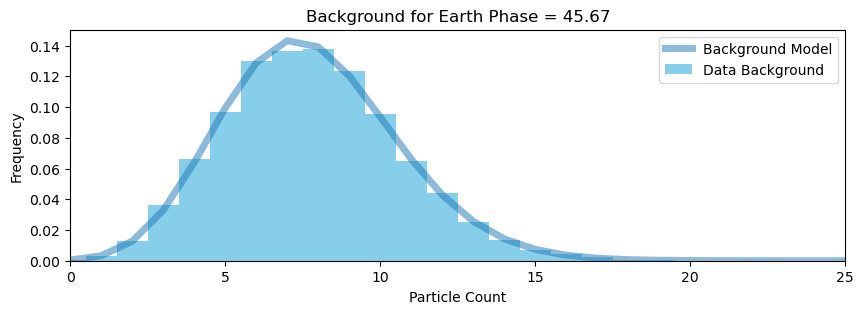

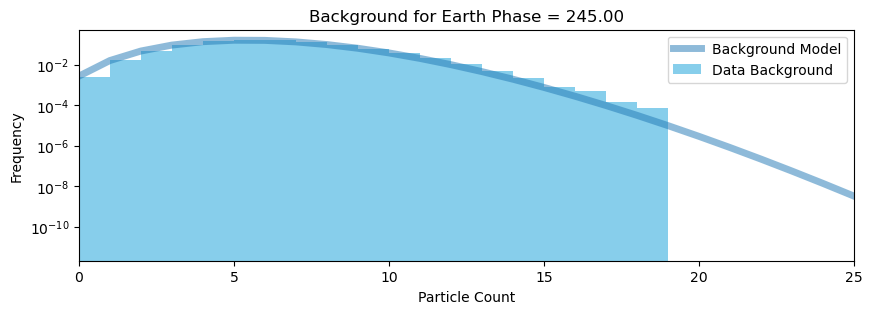

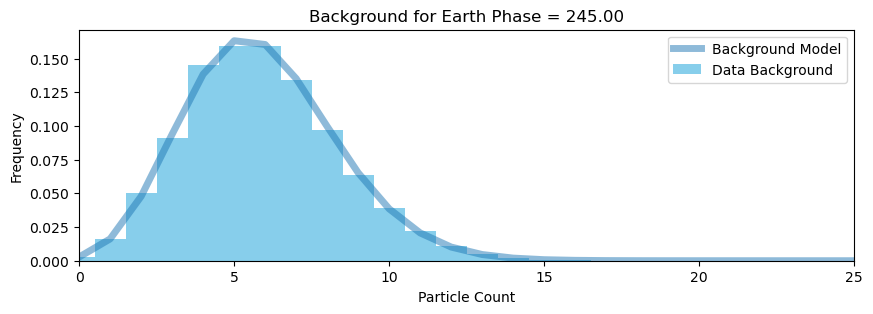

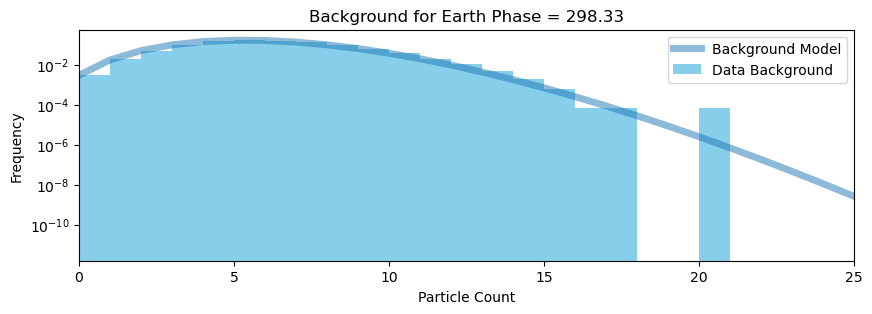

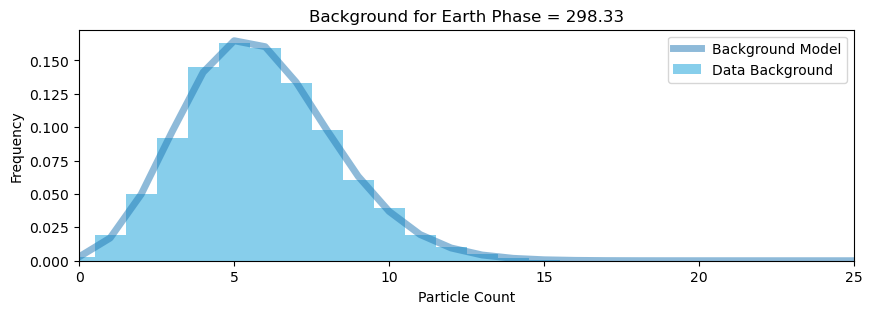

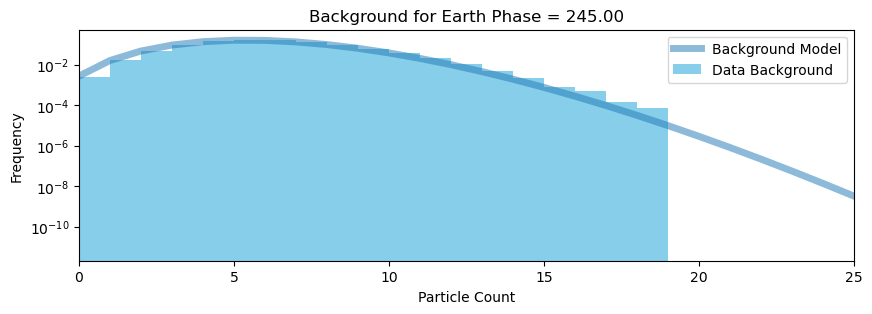

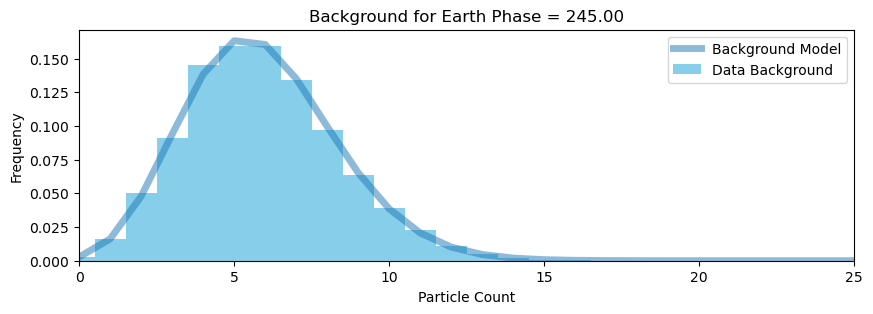

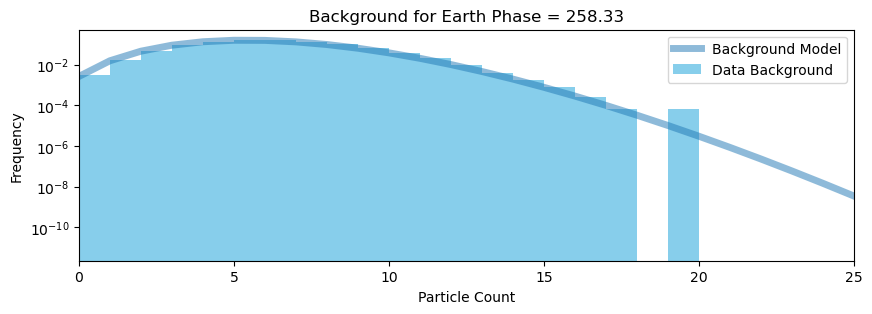

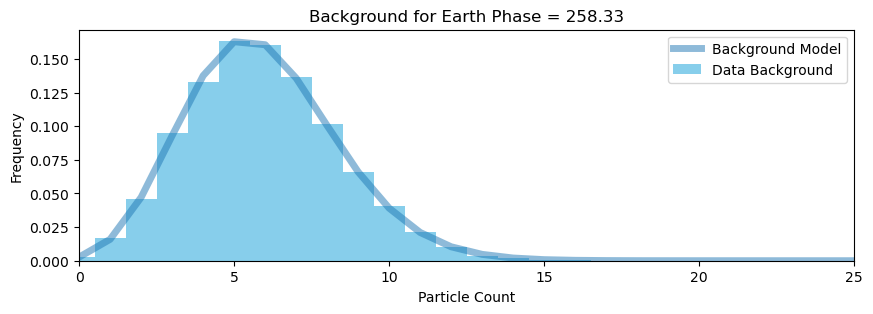

In [52]:
bg_spread(100)
bg_spread(300000)
bg_spread(200000)
bg_spread(30000)
bg_spread(950000)

#### 4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

In [32]:
def fiveSigTenthD(n):
    #n=1099000

    D = Data[(Data["Earth Longitude"] < Data.at[n+15,'Earth Longitude'])]
    D = D[(D["Earth Longitude"] >= Data.at[n-15,'Earth Longitude'])]
    
    mu=D.mean()
    p = stats.norm.cdf(5)
    s=scipy.stats.poisson.ppf(p,mu[3], loc=0)
    #print(s)
    return(s)

In [18]:
times = [34100, 3410000, 3400, 39084, 988943, 4235993]

for i in range(len(times)):
    print("At time = {1:1.0f} we need to see {0:1.0f} particle in a 100 milliseconds span".format(fiveSigTenthD(times[i]),Data.at[times[i],'Time']))


At time = 940683426 we need to see 21 particle in a 100 milliseconds span
At time = 941021016 we need to see 23 particle in a 100 milliseconds span
At time = 940680356 we need to see 24 particle in a 100 milliseconds span
At time = 940683924 we need to see 21 particle in a 100 milliseconds span
At time = 940778910 we need to see 22 particle in a 100 milliseconds span
At time = 941103615 we need to see 22 particle in a 100 milliseconds span


### Problem 2

#### 1) Dowload the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.

In [19]:
hf = h5py.File('images.h5', 'r')
print(hf.keys())
imageStack = np.array(hf.get('imagestack'))

<KeysViewHDF5 ['image1', 'imagestack']>


#### 2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

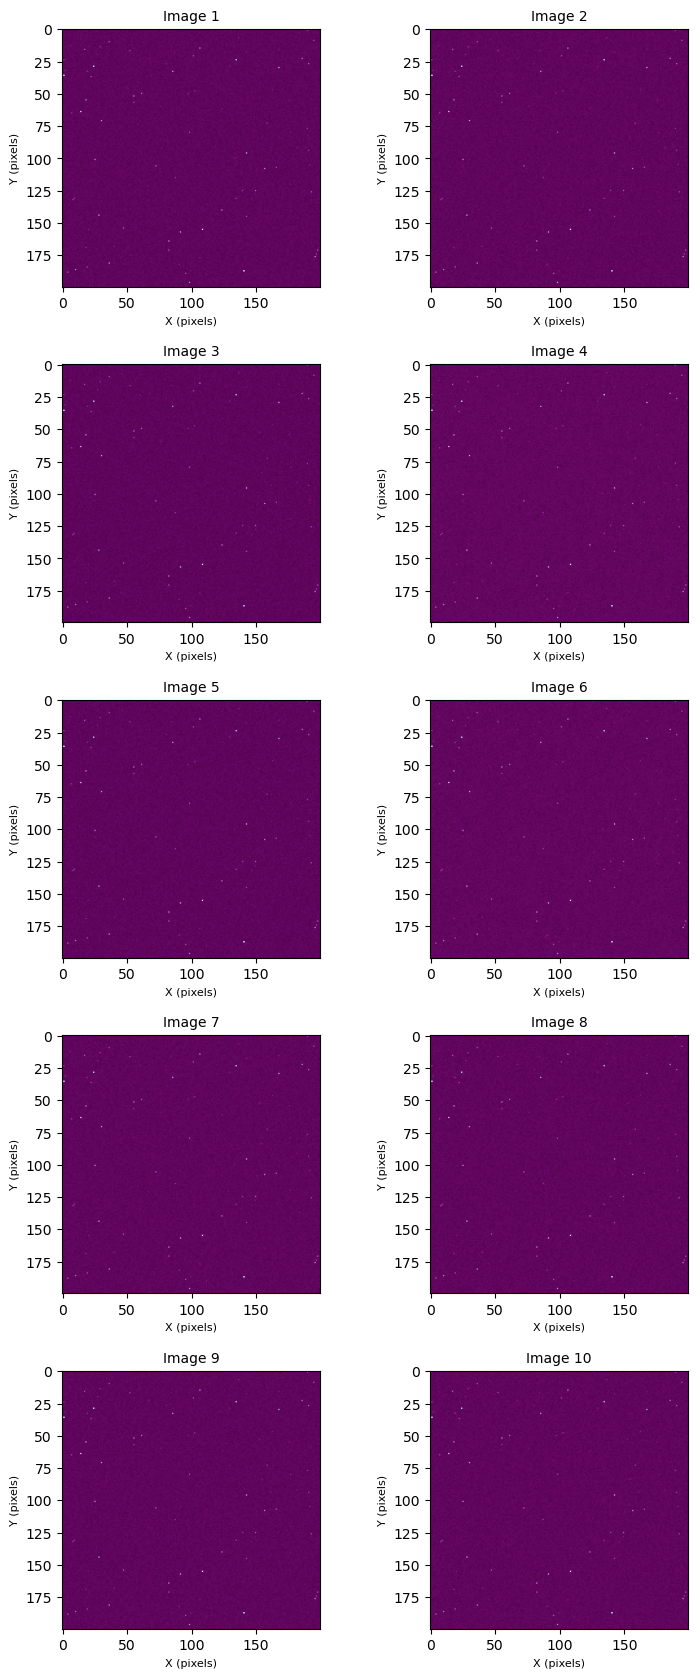

In [53]:
plt.rcParams["figure.figsize"] = (10,20)
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.title('Image ' + str(i+1), fontsize=10)
    plt.xlabel('X (pixels)', fontsize=8)
    plt.ylabel('Y (pixels)', fontsize=8)
    plt.imshow(imageStack[:,:,i], cmap=plt.cm.BuPu_r)


plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=.3)

plt.show()

From each of the ten images it appears that there is not a time dependence on the data, but that there might be some spatial differences by what we can see from each consecutive image. 

#### 3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you fin

In [54]:
for i in range(9):
    subImage = imageStack[:,:,i] - imageStack[:,:,i+1]

In [72]:
changes = np.array([])
for i in range(9):
    for j in range(200):
        changes = np.append(changes,subImage[j])
    

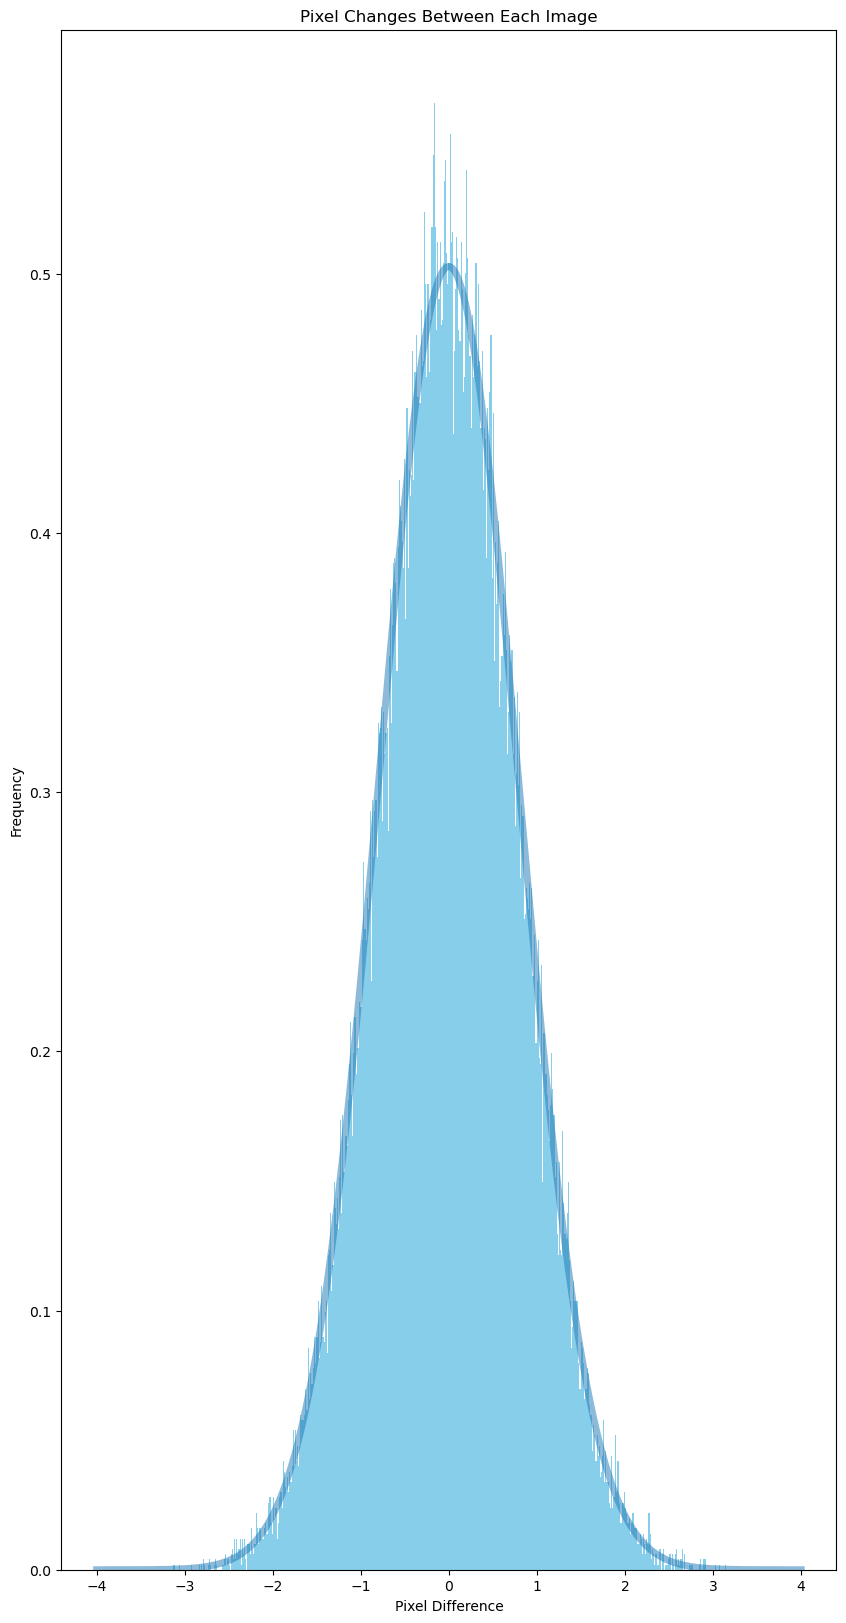

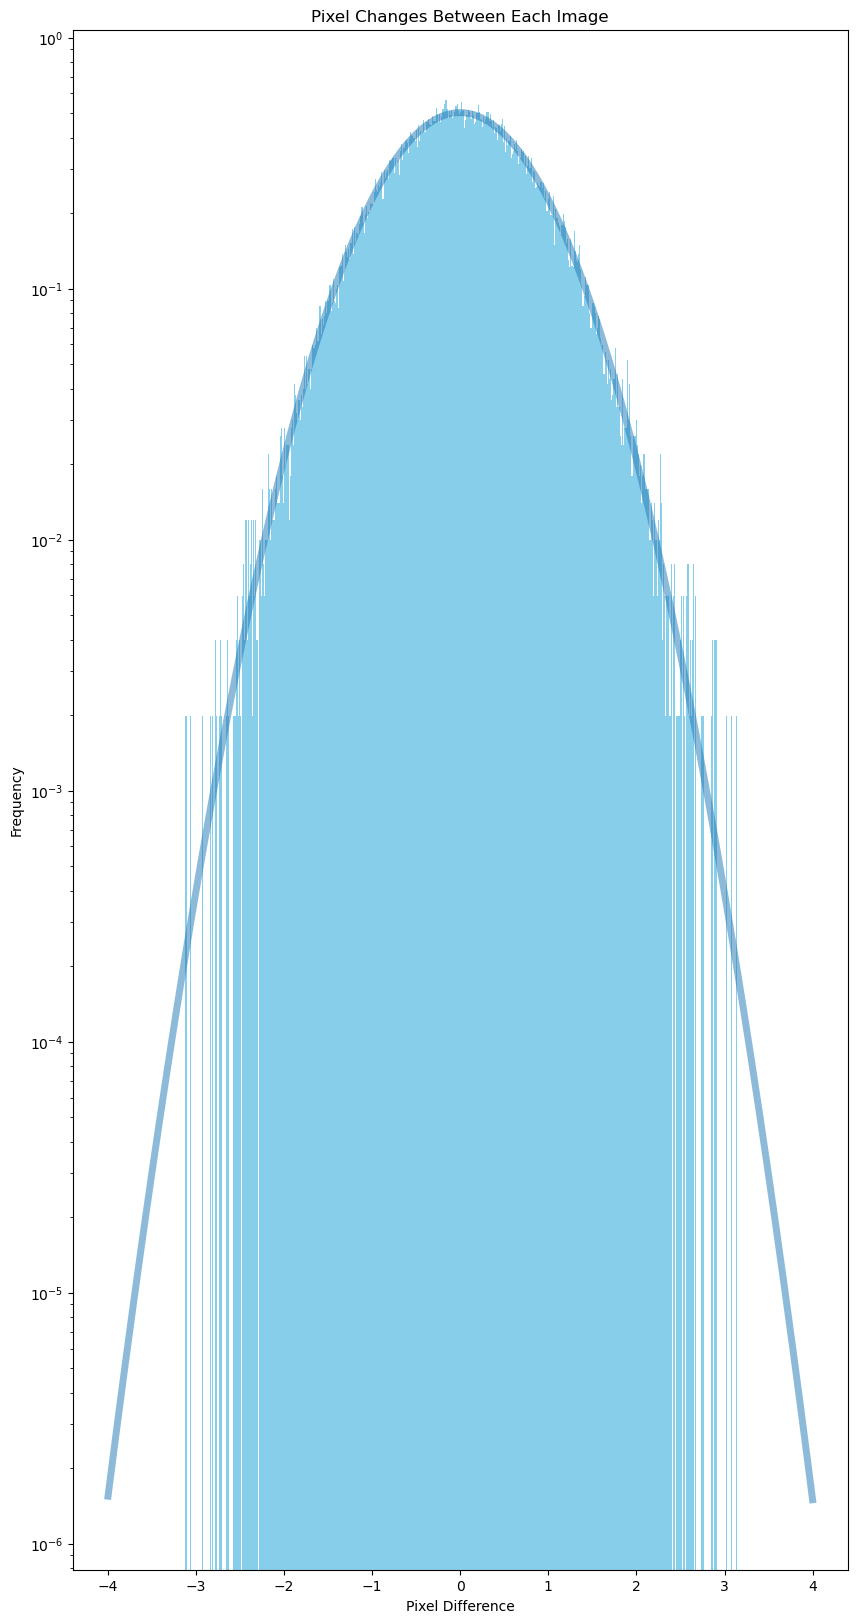

In [73]:
mean=np.mean(changes)
mu =np.sqrt(np.var(changes))
x = np.linspace(-4,4,1000)


fig, ax = plt.subplots(1,1)

ax.plot(x,stats.norm.pdf(x,loc=mean,scale = mu), linewidth = 5, alpha = .5)

plt.hist(changes, bins=500, density= True, color = 'skyblue')
plt.xlabel('Pixel Difference')
plt.ylabel('Frequency')
plt.title('Pixel Changes Between Each Image')


fig, ax = plt.subplots(1,1)

ax.plot(x,stats.norm.pdf(x,loc=mean,scale = mu), linewidth = 5, alpha = .5)

plt.hist(changes, bins=500, density= True, color = 'skyblue')
plt.yscale('log')
plt.xlabel('Pixel Difference')
plt.ylabel('Frequency')
plt.title('Pixel Changes Between Each Image')
plt.show()

In [113]:
sigma = 5
prob = stats.norm.sf(sigma)
print(f'The probability for a 5 sigma event is {prob}.')
width = 0.588
max_diff = stats.norm.isf(prob, loc = 0, scale = width)
print(f'Pixels with intensities over {max_diff:.2f} will be considered transients.')

The probability for a 5 sigma event is 2.866515718791933e-07.
Pixels with intensities over 2.94 will be considered transients.


In [111]:
transients = []

for i in range(len(changes)):
    if changes[i] >= 2.94:
        transients.append(changes[i])

In [116]:
print('With threshold of 5 sigma and maximum intensity of 2.94, I found: ', len(transients), 'transients.')

With threshold of 5 sigma and maximum intensity of 2.94, I found:  27 transients.


#### 4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

We should get different pdfs because we are looking for different kinds of signals. I was looking for a transient, so a bright spot, but my partner is searching for faint or dark spots.